In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('events.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
#df["storage"] = df["storage"].astype('category')

In [3]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

Ordenamos primero respecto al tiempo y luego con un sort in place ordenamos respecto a las personas.
De esta forma nos quedan todos los logs de una misma persona juntos y ordenados respecto al tiempo

In [4]:
df.sort_values(by=['timestamp']).sort_values(by=['person'], inplace = True)

In [5]:
df['timediff'] = df['timestamp'].diff()
df['timediff'] = df['timediff'].dt.total_seconds()

df['newperson']= df['person'].apply(lambda x: int(x, 16))
df['newperson'] = df['newperson'].diff()
df['newperson'] = (df['newperson'] > 0)

Text(0.5,0,'diff')

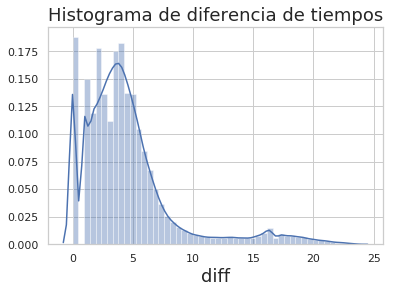

In [6]:
minidf = df.loc[(df['newperson'] == False) & (df['timediff'])]["timediff"]
minidf = np.log2(minidf)
g = sns.distplot(minidf)
g.set_title("Histograma de diferencia de tiempos", fontsize=18)
g.set_xlabel("diff",fontsize=18)


In [7]:
maxtime = 16368

In [8]:
df['viewed_product'] = (df['event'] == 'viewed product')
df['brand_listing'] = (df['event'] == 'brand listing')
df['visited_site'] = (df['event'] == 'visited site')
df['ad_campaign_hit'] = (df['event'] == 'ad campaign hit')
df['generic_listing'] = (df['event'] == 'generic listing')
df['searched_products'] = (df['event'] == 'searched products')
df['search_engine_hit'] = (df['event'] == 'search engine hit')
df['checkout'] = (df['event'] == 'checkout')
df['staticpage'] = (df['event'] == 'staticpage')
df['conversion'] = (df['event'] == 'conversion')
df['lead'] = (df['event'] == 'lead')
df['ad_url_model'] = ((df['url'].str.count('/') == 3) & (df['url'].str.contains('comprar')))
df['ad_url_brand'] = ((df['url'].str.count('/') == 2) & (df['url'].str.contains('comprar')))

In [9]:
df['newentry'] = ((df['timediff'] > maxtime) | (df['newperson']))
df['entry'] = df['newentry'].cumsum()

In [10]:
df['already_buyed'] = (df['conversion'] > 0)
df['already_buyed'] = df.groupby('person')['already_buyed'].cumsum()
df['already_buyed'] = (df['already_buyed'] > 0) & (df['already_buyed'].shift(1) > 0)
df['first_convertion'] = (df['event'] == 'conversion') & (df['already_buyed'] == False)

In [11]:
def primero(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
            break
    if lista:
        return lista.pop(0)
    return np.nan

def listar(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
    if lista:
        return lista
    return []

dict1 = ({'timestamp':primero, 'person':primero, 'sku':listar, 'model':listar, 'condition':listar,'storage':primero, 'color':listar, 'skus':listar, 
          'search_term':listar, 'staticpage':'sum','campaign_source':primero, 'search_engine':primero, 'channel':primero, 'new_vs_returning':primero,
          'city':primero, 'region':primero, 'country':primero, 'device_type':primero, 'screen_resolution':primero, 'operating_system_version':primero, 
          'browser_version':primero, 'day_of_week':primero, 'month':primero,'hour':primero, 'viewed_product':'sum', 'brand_listing':'sum',
          'visited_site':'sum', 'ad_campaign_hit':'sum', 'generic_listing':'sum','searched_products':'sum', 'search_engine_hit':'sum', 'checkout':'sum', 
          'conversion':'sum','lead':'sum', 'ad_url_model':'sum', 'ad_url_brand':'sum', 'newperson':primero, 'already_buyed':sum, 'first_convertion':sum})

entrydf = df.groupby('entry').agg(dict1)
entrydf['already_buyed'] = (entrydf['already_buyed'] >0)

In [12]:
def calcular_retencion(df):
    if df['conversion'] > 1:
        return 'multiple_conversions'
    
    if df['conversion'] > 0:
        return 'conversion'
    
    if df['checkout'] > 0:
        return 'checkout'
    
    if df['lead'] > 0:
        return 'lead'
    
    if df['searched_products'] > 0:
        return 'searched_products'
    
    if ((df['viewed_product'] > 0) & (df['ad_url_model'] == 0)) | (df['viewed_product'] > 1):
        return 'viewed_product'
    
    if ((df['brand_listing'] > 0) & (df['ad_url_brand'] == 0)) | (df['brand_listing'] > 1):
        return 'brand_listing'
    
    if df['generic_listing'] > 0:
        return 'generic_listing'
    
    if df['search_engine_hit'] > 0:
        return 'search_engine_hit'
    
    if df['visited_site'] > 0:
        return 'visited_site'
    
    return 'ad_campaing_hit' #el default es esto porque por algun motivo algunos logs que solo hacian ad_campaing_hit se quedaban sin esta columna
    
entrydf['retention'] = entrydf.apply(calcular_retencion, axis=1).astype('category')

In [13]:
viewed_product_df = df.loc[df['event'] == 'viewed product'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
brand_listing_df = df.loc[df['event'] == 'brand listing'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
visited_site_df = df.loc[df['event'] == 'visited site'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
ad_campaign_hit_df = df.loc[df['event'] == 'ad campaign hit'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
generic_listing_df = df.loc[df['event'] == 'generic listing'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
searched_products_df = df.loc[df['event'] == 'searched products'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
search_engine_hit_df = df.loc[df['event'] == 'search engine hit'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
checkout_df = df.loc[df['event'] == 'checkout'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
staticpage_df = df.loc[df['event'] == 'staticpage'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
conversion_df = df.loc[df['event'] == 'conversion'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')
lead_df = df.loc[df['event'] == 'lead'].dropna(axis='columns', how = 'all').drop('event', axis = 'columns')

ad_campaign_hit_df.describe(include = 'all')

,timestamp,person,url,staticpage,campaign_source,day_of_week,month,hour,timediff,newperson,...,search_engine_hit,checkout,conversion,lead,ad_url_model,ad_url_brand,newentry,entry,already_buyed,first_convertion
count,82827,82827,82756,82827,82796,"82,827.00","82,827.00","82,827.00","82,826.00",82827,...,82827,82827,82827,82827,82827,82827,82827,"82,827.00",82827,82827
unique,82044,21312,227,1,24,nan,nan,nan,nan,2,...,1,1,1,1,2,2,2,nan,2,1
top,2018-06-04 20:11:05,a202cfba,/,False,google,nan,nan,nan,nan,False,...,False,False,False,False,True,False,False,nan,False,False
freq,5,279,28323,82827,58153,nan,nan,nan,nan,77230,...,82827,82827,82827,82827,45879,74713,69338,nan,76958,82827
first,2018-01-01 07:32:26,NaN,NaN,NaN,NaN,nan,nan,nan,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
last,2018-06-15 23:58:00,NaN,NaN,NaN,NaN,nan,nan,nan,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.77,4.81,13.37,"6,923.36",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"35,955.65",NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.91,1.13,7.36,"827,318.08",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"20,924.88",NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,"-13,904,557.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.00,4.00,9.00,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"17,926.50",NaN,NaN


In [14]:
entrydf.columns

Index(['condition', 'channel', 'browser_version', 'hour', 'visited_site',
       'campaign_source', 'lead', 'timestamp', 'device_type', 'already_buyed',
       'model', 'screen_resolution', 'brand_listing', 'storage',
       'new_vs_returning', 'month', 'search_engine', 'conversion', 'checkout',
       'newperson', 'country', 'generic_listing', 'ad_url_brand',
       'viewed_product', 'day_of_week', 'color', 'staticpage',
       'first_convertion', 'city', 'region', 'search_term',
       'searched_products', 'person', 'search_engine_hit',
       'operating_system_version', 'skus', 'sku', 'ad_campaign_hit',
       'ad_url_model', 'retention'],
      dtype='object')

Text(0,0.5,'Retencion')

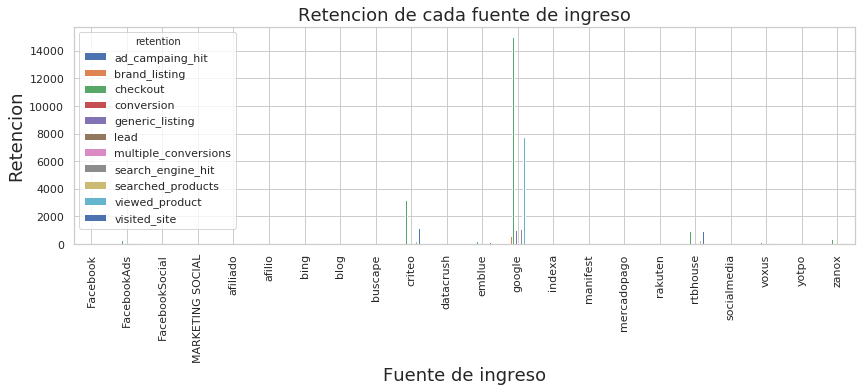

In [15]:
plot=pd.crosstab(entrydf['campaign_source'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de cada fuente de ingreso", fontsize=18)
plot.set_xlabel("Fuente de ingreso",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

Text(0,0.5,'Retencion')

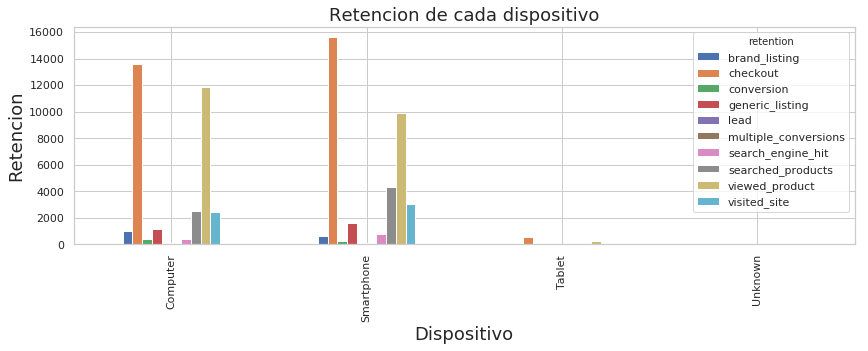

In [16]:
plot=pd.crosstab(entrydf['device_type'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de cada dispositivo", fontsize=18)
plot.set_xlabel("Dispositivo",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

Text(0,0.5,'Retencion')

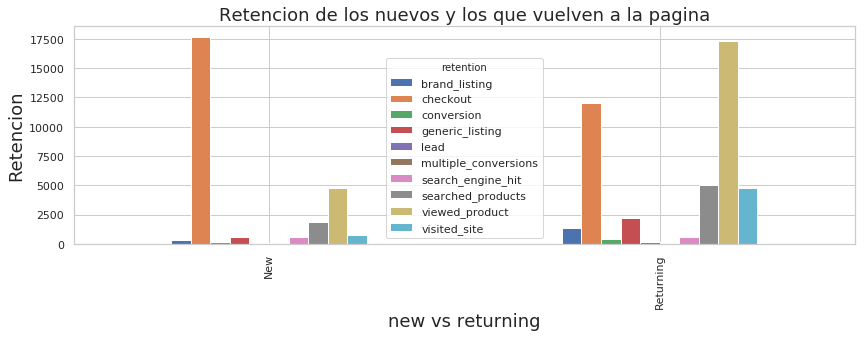

In [17]:
plot=pd.crosstab(entrydf['new_vs_returning'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de los nuevos y los que vuelven a la pagina", fontsize=18)
plot.set_xlabel("new vs returning",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

Text(0,0.5,'Retencion')

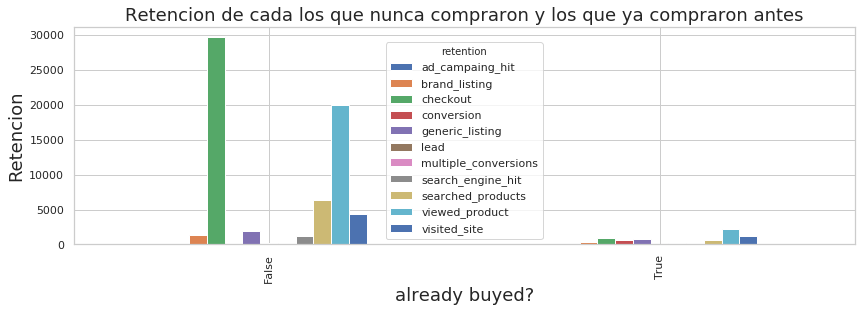

In [18]:
plot=pd.crosstab(entrydf['already_buyed'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de cada los que nunca compraron y los que ya compraron antes", fontsize=18)
plot.set_xlabel("already buyed?",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

In [24]:
modeldf = df.groupby('model')['event'].count().nlargest(10, keep = 'first')
modeldf

model
iPhone 6                  50916
iPhone 5s                 44878
iPhone 6S                 39296
iPhone 7                  27556
Samsung Galaxy S7 Edge    23926
Samsung Galaxy S7         19337
iPhone 7 Plus             18792
Samsung Galaxy S8         16959
iPhone SE                 16531
Samsung Galaxy J5         13044
Name: event, dtype: int64